In [ ]:
'''import numpy as np
import pandas as pd

# 1) 파일 로드
df = pd.read_csv("final_monthly.csv")

# 2) 컬럼명 정리
df.columns = df.columns.str.strip()

# 3) 날짜 처리
df['date'] = pd.PeriodIndex(df['date'].astype(str).str.strip(), freq='M')
df = df.sort_values('date').set_index('date')

# 4) 숫자형 변환
for c in df.columns:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.replace(',', '').str.replace('%', '').str.strip(),
        errors='coerce'
    )

# 5) rename 
rename_map = {
    "경제정책 불확실성 지수(EPU)": "epu_index",
    "기준 금리": "bok_rate",
    "뉴스심리지수": "news_sentiment",
    "산업생산지수 갭": "output_gap",
    "산업생산증가율": "ip_growth",
    "인플레이션 갭(소비자물가지수)": "cpi_infl_gap",
    "콜 금리": "call_rate_m",
    "final_monthly_tone": "tone"
}

df = df.rename(columns=rename_map)

print(df.columns.tolist())

# 6) 저장 (이게 진짜 최종본)
df.to_csv("final_monthly_renamed.csv", encoding="utf-8-sig")'''


['epu_index', 'bok_rate', 'delta_bok', 'news_sentiment', 'output_gap', 'ip_growth', 'cpi_infl_gap', 'call_rate_m', 'tone']


In [13]:
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\eeyy1\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


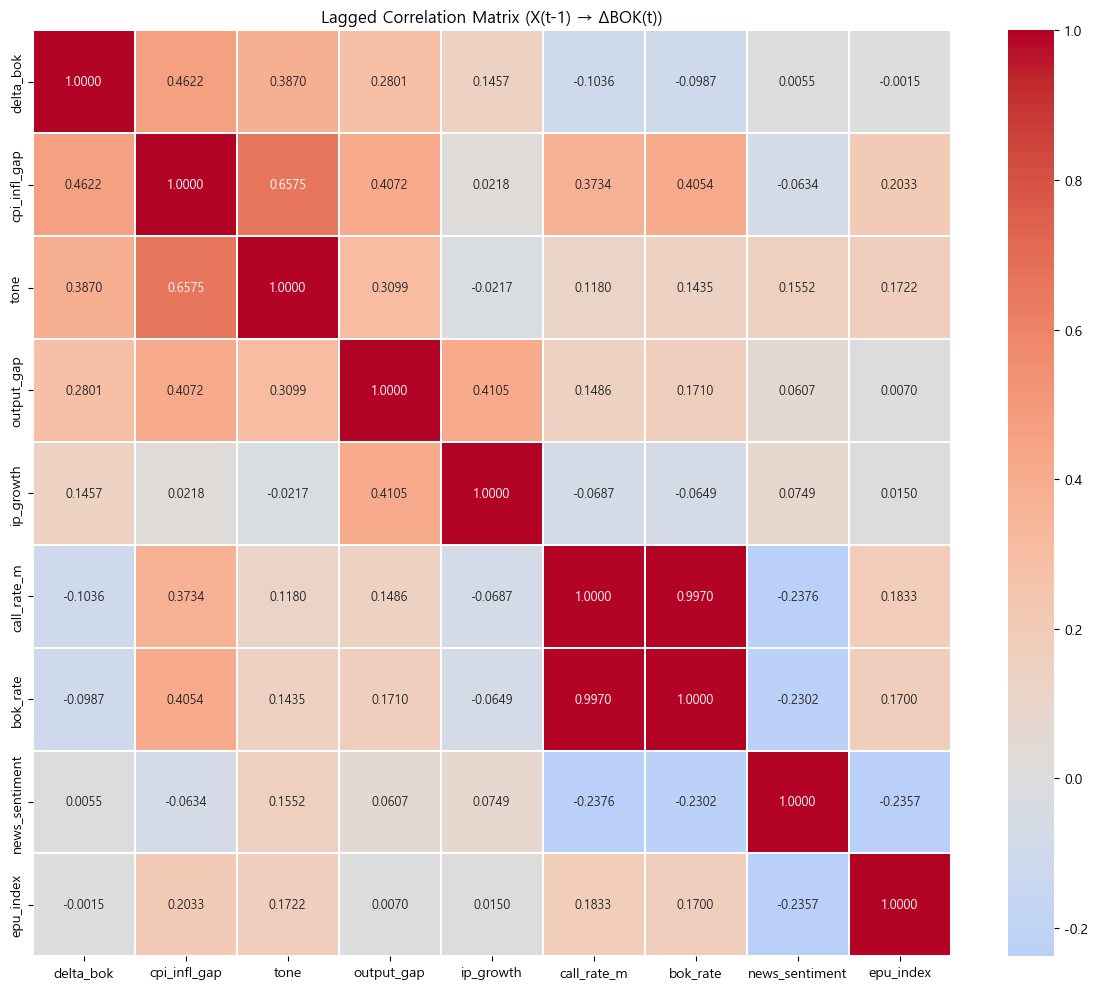


[Correlation with delta_bok | X lagged by 1]
delta_bok         1.000000
cpi_infl_gap      0.462180
tone              0.387033
output_gap        0.280115
ip_growth         0.145718
call_rate_m      -0.103629
bok_rate         -0.098688
news_sentiment    0.005515
epu_index        -0.001503
Name: delta_bok, dtype: float64


In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===== 0) 로드 =====
df = pd.read_csv("final_monthly_merged_renamed.csv")

# date → PeriodIndex
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.to_period("M")
df = df.sort_values("date").set_index("date")

# ===== 한글 폰트 =====
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ===== 1) 숫자 변수만 =====
df_num = df.select_dtypes(include=[np.number]).copy()

# z_ 제거 (안전)
z_cols = [c for c in df_num.columns if c.lower().startswith("z_")]
df_num = df_num.drop(columns=z_cols, errors="ignore")

target = "delta_bok"
feature_cols = [c for c in df_num.columns if c != target]

# ===== 2) Lag 적용 =====
df_lagged = df_num.copy()
df_lagged[feature_cols] = df_lagged[feature_cols].shift(1)

# 결측 제거 (t-1 때문에 생긴 첫 달 + macro 없는 구간 자동 제거)
df_lagged = df_lagged.dropna()

# ===== 3) 상관계수 =====
corr_all = df_lagged.corr()

# delta_bok 기준 정렬
order = corr_all[target].abs().sort_values(ascending=False).index
corr_sorted = corr_all.loc[order, order]

# ===== 4) 히트맵 =====
plt.figure(
    figsize=(max(12, 0.8 * len(corr_sorted)),
             max(10, 0.8 * len(corr_sorted)))
)
sns.heatmap(
    corr_sorted,
    annot=True,
    fmt=".4f",
    cmap="coolwarm",
    center=0,
    linewidths=0.3,
    annot_kws={"size": 9}
)
plt.title("Lagged Correlation Matrix (X(t-1) → ΔBOK(t))")
plt.tight_layout()
plt.show()

# ===== 5) delta_bok 상관만 출력 =====
corr_with_target = corr_all[target].sort_values(
    key=lambda s: s.abs(), ascending=False
)

print("\n[Correlation with delta_bok | X lagged by 1]")
print(corr_with_target)


[선택된 변수 | |corr| ≥ 0.2]
['cpi_infl_gap', 'tone', 'output_gap']


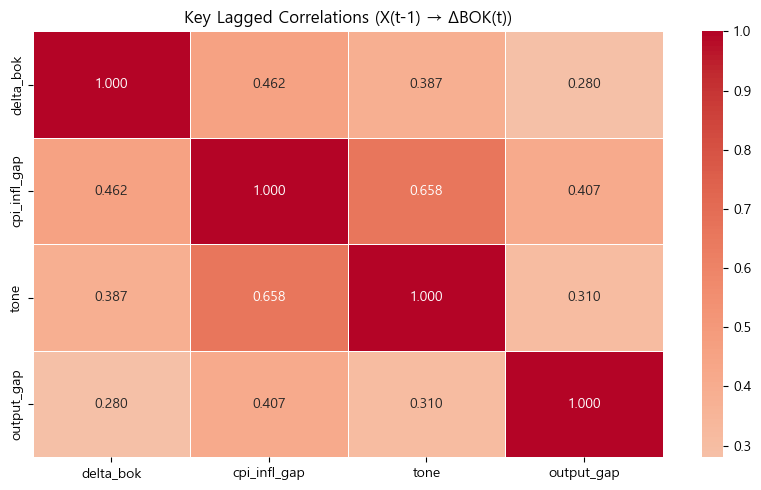

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# =========================
# 1) threshold 설정
# =========================
threshold = 0.2
target = "delta_bok"

# =========================
# 2) |corr| ≥ threshold 인 변수 선택
# =========================
selected_vars = (
    corr_all[target]
    .drop(target)                      # 자기 자신 제거
    .loc[lambda s: s.abs() >= threshold]
    .sort_values(key=lambda s: s.abs(), ascending=False)
    .index
)

print("[선택된 변수 | |corr| ≥ 0.2]")
print(selected_vars.tolist())

# =========================
# 3) 히트맵용 변수 리스트
# =========================
heatmap_vars = [target] + list(selected_vars)

# =========================
# 4) 히트맵
# =========================
plt.figure(figsize=(6 + 0.6 * len(heatmap_vars), 5))
sns.heatmap(
    corr_all.loc[heatmap_vars, heatmap_vars],
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Key Lagged Correlations (X(t-1) → ΔBOK(t))")
plt.tight_layout()
plt.show()


In [29]:
%pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\eeyy1\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [58]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# =========================
# 0) 데이터 로드 (최종 병합본)
# =========================
df_final = pd.read_csv("final_monthly_merged_renamed.csv")

# date → PeriodIndex
df_final["date"] = pd.to_datetime(df_final["date"], errors="coerce").dt.to_period("M")
df_final = df_final.sort_values("date").set_index("date")

# =========================
# 1) Lag-1 회귀 함수
# =========================
def run_final_analysis(df, target_col, feature_cols, maxlags=4):
    """
    t-1 시차 회귀분석:
    - y: target_col (t)
    - X: feature_cols → shift(1) → X(t-1)
    - White(HC1) & HAC(Newey-West)
    """
    df_ana = df.copy()
    df_ana.columns = df_ana.columns.str.strip()

    # 숫자형 변환
    for c in set(feature_cols + [target_col]):
        if c in df_ana.columns:
            df_ana[c] = pd.to_numeric(
                df_ana[c].astype(str)
                          .str.replace(",", "", regex=False)
                          .str.replace("%", "", regex=False)
                          .str.strip(),
                errors="coerce"
            )

    # X만 lag 1
    df_ana[feature_cols] = df_ana[feature_cols].shift(1)

    # 결측 제거
    df_ana = df_ana.dropna(subset=feature_cols + [target_col])

    # 회귀
    X = sm.add_constant(df_ana[feature_cols])
    y = df_ana[target_col]

    model_white = sm.OLS(y, X).fit(cov_type="HC1")
    model_hac   = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})

    # 결과 테이블
    out = pd.DataFrame({
        "Variable": X.columns,
        "Coef(HAC)": model_hac.params.values,
        "White_P": model_white.pvalues.values,
        "HAC_P": model_hac.pvalues.values
    }).round(4)

    print(f"=== OLS (X(t-1) → y(t)) | R² = {model_white.rsquared:.4f} ===")
    print(f"분석 기간: {df_ana.index.min()} ~ {df_ana.index.max()}")
    print(f"HAC maxlags = {maxlags}")
    print("-" * 60)

    return out, model_white, model_hac, df_ana


# =========================
# 2) 실행부 (상관분석 기반 변수)
# =========================
target_col = "delta_bok"

# |corr| ≥ 0.2 + 논문처럼 ΔBOK(t-1) 포함
feature_cols = [
    "delta_bok",        # ΔBOK(t-1)
    "cpi_infl_gap",
    "output_gap",
    "tone"
]

final_results, model_white, model_hac, df_used = run_final_analysis(
    df=df_final,
    target_col=target_col,
    feature_cols=feature_cols,
    maxlags=4
)

final_results


=== OLS (X(t-1) → y(t)) | R² = 1.0000 ===
분석 기간: 2012-02 ~ 2025-11
HAC maxlags = 4
------------------------------------------------------------


,Variable,Coef(HAC),White_P,HAC_P
0,const,0.0,0.8015,0.9033
1,delta_bok,1.0,0.0000,0.0000
2,cpi_infl_gap,0.0,0.0000,0.0016
3,output_gap,0.0,0.1889,0.4464
4,tone,-0.0,0.0009,0.0335


=== OLS (X lagged by 1) | R-squared: 0.2346 ===
분석 대상 기간: 2012-02 ~ 2025-08
HAC maxlags = 4
------------------------------------------------------------
=== [RAW] Lag-1 OLS (White R² 기준) ===
기간: 2012-02 ~ 2025-08 | n=164 | R²=1.0000 | Adj R²=1.0000 | HAC maxlags=4

=== [STANDARDIZED X] Lag-1 OLS (White R² 기준) ===
기간: 2012-02 ~ 2025-08 | n=164 | R²=1.0000 | Adj R²=1.0000 | HAC maxlags=4

=== [STANDARDIZED X] tone 제외 모델 ===
기간: 2012-02 ~ 2025-08 | n=166 | R²=1.0000 | Adj R²=1.0000 | HAC maxlags=4

=== tone 포함/제외 R² 비교(White 기준) ===
          Model   R2  Adj_R2    n
0     With tone  1.0     1.0  164
1  Without tone  1.0     1.0  166


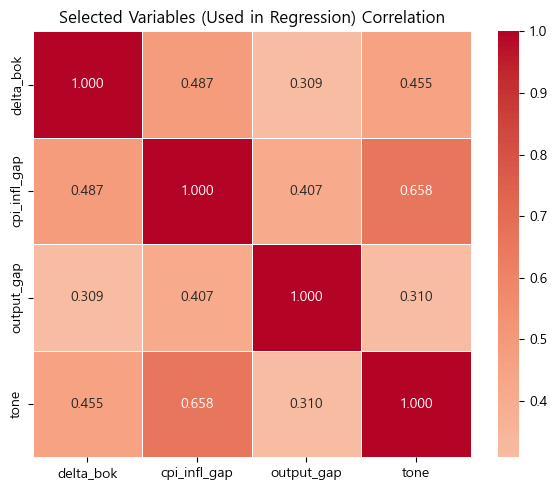

In [ ]:
# =========================
# 2) 메인 함수: Lag-1 OLS + (White/HAC) + 옵션 표준화
# =========================
def run_final_analysis(
    df: pd.DataFrame,
    target_col: str,
    feature_cols: list,
    maxlags: int = 4,
    standardize_cols=None,   # 표준화할 X 컬럼들(=feature_cols 중 일부)
    digits: int = 6          # 출력 소수 자리
):
    """
    t-1 시차 회귀분석:
    - y: target_col (t)
    - X: feature_cols를 shift(1) 해서 X(t-1)로 y(t) 설명
    - 표준화 옵션: standardize_cols에 지정된 X만 z-score
    - White(HC1) / HAC(Newey-West) 둘 다 산출
    """
    df_ana = df.copy()

    # 0) 컬럼명 공백 제거
    df_ana.columns = df_ana.columns.str.strip()

    # 1) 필요한 컬럼 숫자형 변환
    need_cols = list(set(feature_cols + [target_col]))
    for c in need_cols:
        if c in df_ana.columns:
            df_ana[c] = _to_numeric_safe(df_ana[c])

    # 2) X만 lag1 (y는 그대로)
    df_ana[feature_cols] = df_ana[feature_cols].shift(1)

    # 3) 결측 제거
    df_ana = df_ana.dropna(subset=feature_cols + [target_col]).copy()

    # 4) (옵션) X 표준화: 지정된 컬럼만
    if standardize_cols is not None and len(standardize_cols) > 0:
        for c in standardize_cols:
            if c in df_ana.columns:
                std = df_ana[c].std(ddof=0)
                if std == 0 or np.isnan(std):
                    continue
                df_ana[c] = (df_ana[c] - df_ana[c].mean()) / std

    # 5) 회귀
    X = sm.add_constant(df_ana[feature_cols])
    y = df_ana[target_col]

    model_white = sm.OLS(y, X).fit(cov_type="HC1")
    model_hac   = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})

    # 6) 결과표(계수는 HAC 기준 + pvalue 둘 다)
    rows = []
    for col in X.columns:
        rows.append({
            "Variable": col,
            "Coef(HAC)": float(model_hac.params[col]),
            "White_P": float(model_white.pvalues[col]),
            "HAC_P": float(model_hac.pvalues[col])
        })

    out = pd.DataFrame(rows).round(digits)

    info = {
        "nobs": int(model_white.nobs),
        "r2": float(model_white.rsquared),
        "adj_r2": float(model_white.rsquared_adj),
        "start": df_ana.index.min(),
        "end": df_ana.index.max(),
        "maxlags": maxlags
    }

    return out, model_white, model_hac, df_ana, info


# =========================
# 3) 실행부
# =========================
# ✅ 이미 df_final = pd.read_csv("final_monthly_merged_renamed.csv") 로 로드된 상태라고 가정!
# ✅ 여기서는 "df_final_renamed" 같은 변수 쓰지 말고 df_final 그대로 사용

df_final = df_final.copy()
df_final.columns = df_final.columns.str.strip()

# (선택) index가 날짜/기간일 때만 의미 있음
df_final = df_final.sort_index()

target_col = "delta_bok"

# (추천) 상관분석 기반 선별 변수 + ΔBOK(t-1) 포함
feature_cols_selected = [
    "delta_bok",      # ΔBOK(t-1)  (shift(1)로 구현)
    "cpi_infl_gap",
    "output_gap",
    "tone"
]

# -------------------------
# A) 원단위(비표준화) 회귀
# -------------------------
res_raw, mW_raw, mH_raw, df_used_raw, info_raw = run_final_analysis(
    df=df_final,
    target_col=target_col,
    feature_cols=feature_cols_selected,
    maxlags=4,
    standardize_cols=None,
    digits=6
)

print("=== [RAW] Lag-1 OLS (White R² 기준) ===")
print(
    f"기간: {info_raw['start']} ~ {info_raw['end']} | "
    f"n={info_raw['nobs']} | R²={info_raw['r2']:.4f} | Adj R²={info_raw['adj_r2']:.4f} | "
    f"HAC maxlags={info_raw['maxlags']}"
)
display(res_raw)


# -------------------------
# B) 표준화 회귀 (해석용 추천)
#   - ΔBOK(t-1)은 그대로 두고
#   - 거시/톤 변수만 표준화
# -------------------------
standardize_cols = ["cpi_infl_gap", "output_gap", "tone"]

res_std, mW_std, mH_std, df_used_std, info_std = run_final_analysis(
    df=df_final,
    target_col=target_col,
    feature_cols=feature_cols_selected,
    maxlags=4,
    standardize_cols=standardize_cols,
    digits=6
)

print("\n=== [STANDARDIZED X] Lag-1 OLS (White R² 기준) ===")
print(
    f"기간: {info_std['start']} ~ {info_std['end']} | "
    f"n={info_std['nobs']} | R²={info_std['r2']:.4f} | Adj R²={info_std['adj_r2']:.4f} | "
    f"HAC maxlags={info_std['maxlags']}"
)
display(res_std)


# -------------------------
# C) (핵심 비교) tone 제외 모델
# -------------------------
feature_cols_no_tone = [
    "delta_bok",
    "cpi_infl_gap",
    "output_gap"
]

res_std_no_tone, mW_std_no_tone, mH_std_no_tone, df_used_std_no_tone, info_std_no_tone = run_final_analysis(
    df=df_final,
    target_col=target_col,
    feature_cols=feature_cols_no_tone,
    maxlags=4,
    standardize_cols=["cpi_infl_gap", "output_gap"],
    digits=6
)

print("\n=== [STANDARDIZED X] tone 제외 모델 ===")
print(
    f"기간: {info_std_no_tone['start']} ~ {info_std_no_tone['end']} | "
    f"n={info_std_no_tone['nobs']} | R²={info_std_no_tone['r2']:.4f} | Adj R²={info_std_no_tone['adj_r2']:.4f} | "
    f"HAC maxlags={info_std_no_tone['maxlags']}"
)
display(res_std_no_tone)


print("\n=== tone 포함/제외 R² 비교(White 기준) ===")
display(pd.DataFrame([
    {"Model": "With tone", "R2": info_std["r2"], "Adj_R2": info_std["adj_r2"], "n": info_std["nobs"]},
    {"Model": "Without tone", "R2": info_std_no_tone["r2"], "Adj_R2": info_std_no_tone["adj_r2"], "n": info_std_no_tone["nobs"]}
]).round(4))


# =========================
# 4) (옵션) 회귀에 실제 사용된 데이터 기준 히트맵
# =========================
heatmap_vars = [target_col] + feature_cols_selected
heatmap_vars = list(dict.fromkeys(heatmap_vars))  # 중복 제거

corr_small = df_used_std[heatmap_vars].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_small, annot=True, fmt=".3f", cmap="coolwarm", center=0, linewidths=0.4)
plt.title("Selected Variables (Used in Regression) Correlation")
plt.tight_layout()
plt.show()








=== [RAW] Lag-1 OLS (White R² 기준) ===
기간: 2012-02 ~ 2025-11 | n=166 | R²=1.0000 | Adj R²=1.0000 | HAC maxlags=4


,Variable,Coef(HAC),White_P,HAC_P
0,const,0.0,0.801499,0.903311
1,delta_bok,1.0,0.000000,0.000000
2,cpi_infl_gap,0.0,0.000000,0.001608
3,output_gap,0.0,0.188860,0.446432
4,tone,-0.0,0.000878,0.033476



=== [STANDARDIZED X] Lag-1 OLS (White R² 기준) ===
기간: 2012-02 ~ 2025-11 | n=166 | R²=1.0000 | Adj R²=1.0000 | HAC maxlags=4


,Variable,Coef(HAC),White_P,HAC_P
0,const,0.0,0.071278,0.180856
1,delta_bok,1.0,0.000000,0.000000
2,cpi_infl_gap,-0.0,0.318623,0.434342
3,output_gap,0.0,0.000836,0.020210
4,tone,-0.0,0.000034,0.001084



=== [STANDARDIZED X] tone 제외 모델 ===
기간: 2012-02 ~ 2025-11 | n=166 | R²=1.0000 | Adj R²=1.0000 | HAC maxlags=4


,Variable,Coef(HAC),White_P,HAC_P
0,const,0.0,0.252513,0.547519
1,delta_bok,1.0,0.000000,0.000000
2,cpi_infl_gap,0.0,0.000009,0.016169
3,output_gap,0.0,0.000047,0.015600



=== tone 포함/제외 R² 비교(White 기준) ===


,Model,R2,Adj_R2,n
0,With tone,1.0,1.0,166
1,Without tone,1.0,1.0,166


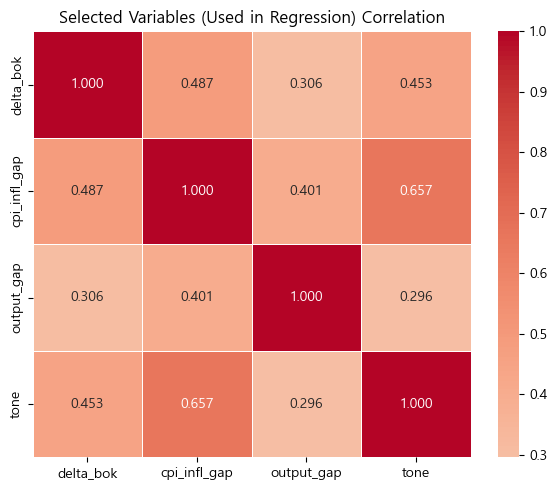

In [59]:
# =========================
# 메인 함수: Lag-1 OLS + (White/HAC) + 옵션 표준화
# =========================
def run_final_analysis(
    df: pd.DataFrame,
    target_col: str,
    feature_cols: list,
    maxlags: int = 4,
    standardize_cols=None,   # 표준화할 X 컬럼들(=feature_cols 중 일부)
    digits: int = 6          # 출력 소수 자리
):
    """
    t-1 시차 회귀분석:
    - y: target_col (t)
    - X: feature_cols를 shift(1) 해서 X(t-1)로 y(t) 설명
    - 표준화 옵션: standardize_cols에 지정된 X만 z-score
    - White(HC1) / HAC(Newey-West) 둘 다 산출
    """
    df_ana = df.copy()

    # 0) 컬럼명 공백 제거
    df_ana.columns = df_ana.columns.str.strip()

    # 1) 필요한 컬럼 숫자형 변환
    need_cols = list(set(feature_cols + [target_col]))
    for c in need_cols:
        if c in df_ana.columns:
            df_ana[c] = _to_numeric_safe(df_ana[c])

    # 2) X만 lag1 (y는 그대로)
    df_ana[feature_cols] = df_ana[feature_cols].shift(1)

    # 3) 결측 제거
    df_ana = df_ana.dropna(subset=feature_cols + [target_col]).copy()

    # 4) (옵션) X 표준화: 지정된 컬럼만
    if standardize_cols is not None and len(standardize_cols) > 0:
        for c in standardize_cols:
            if c in df_ana.columns:
                std = df_ana[c].std(ddof=0)
                if std == 0 or np.isnan(std):
                    continue
                df_ana[c] = (df_ana[c] - df_ana[c].mean()) / std

    # 5) 회귀
    X = sm.add_constant(df_ana[feature_cols])
    y = df_ana[target_col]

    model_white = sm.OLS(y, X).fit(cov_type="HC1")
    model_hac   = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})

    # 6) 결과표(계수는 HAC 기준 + pvalue 둘 다)
    rows = []
    for col in X.columns:
        rows.append({
            "Variable": col,
            "Coef(HAC)": float(model_hac.params[col]),
            "White_P": float(model_white.pvalues[col]),
            "HAC_P": float(model_hac.pvalues[col])
        })

    out = pd.DataFrame(rows).round(digits)

    info = {
        "nobs": int(model_white.nobs),
        "r2": float(model_white.rsquared),
        "adj_r2": float(model_white.rsquared_adj),
        "start": df_ana.index.min(),
        "end": df_ana.index.max(),
        "maxlags": maxlags
    }

    return out, model_white, model_hac, df_ana, info


# =========================
# 실행부
# =========================
# ✅ 이미 df_final = pd.read_csv("final_monthly_merged_renamed.csv") 로 로드된 상태라고 가정!
# ✅ 여기서는 "df_final_renamed" 같은 변수 쓰지 말고 df_final 그대로 사용

df_final = df_final.copy()
df_final.columns = df_final.columns.str.strip()

# (선택) index가 날짜/기간일 때만 의미 있음
df_final = df_final.sort_index()

target_col = "delta_bok"

# (추천) 상관분석 기반 선별 변수 + ΔBOK(t-1) 포함
feature_cols_selected = [
    "delta_bok",      # ΔBOK(t-1)  (shift(1)로 구현)
    "cpi_infl_gap",
    "output_gap",
    "tone"
]

# -------------------------
# A) 원단위(비표준화) 회귀
# -------------------------
res_raw, mW_raw, mH_raw, df_used_raw, info_raw = run_final_analysis(
    df=df_final,
    target_col=target_col,
    feature_cols=feature_cols_selected,
    maxlags=4,
    standardize_cols=None,
    digits=6
)

print("=== [RAW] Lag-1 OLS (White R² 기준) ===")
print(
    f"기간: {info_raw['start']} ~ {info_raw['end']} | "
    f"n={info_raw['nobs']} | R²={info_raw['r2']:.4f} | Adj R²={info_raw['adj_r2']:.4f} | "
    f"HAC maxlags={info_raw['maxlags']}"
)
display(res_raw)


# -------------------------
# B) 표준화 회귀 (해석용 추천)
#   - ΔBOK(t-1)은 그대로 두고
#   - 거시/톤 변수만 표준화
# -------------------------
standardize_cols = ["cpi_infl_gap", "output_gap", "tone"]

res_std, mW_std, mH_std, df_used_std, info_std = run_final_analysis(
    df=df_final,
    target_col=target_col,
    feature_cols=feature_cols_selected,
    maxlags=4,
    standardize_cols=standardize_cols,
    digits=6
)

print("\n=== [STANDARDIZED X] Lag-1 OLS (White R² 기준) ===")
print(
    f"기간: {info_std['start']} ~ {info_std['end']} | "
    f"n={info_std['nobs']} | R²={info_std['r2']:.4f} | Adj R²={info_std['adj_r2']:.4f} | "
    f"HAC maxlags={info_std['maxlags']}"
)
display(res_std)


# -------------------------
# C) (핵심 비교) tone 제외 모델
# -------------------------
feature_cols_no_tone = [
    "delta_bok",
    "cpi_infl_gap",
    "output_gap"
]

res_std_no_tone, mW_std_no_tone, mH_std_no_tone, df_used_std_no_tone, info_std_no_tone = run_final_analysis(
    df=df_final,
    target_col=target_col,
    feature_cols=feature_cols_no_tone,
    maxlags=4,
    standardize_cols=["cpi_infl_gap", "output_gap"],
    digits=6
)

print("\n=== [STANDARDIZED X] tone 제외 모델 ===")
print(
    f"기간: {info_std_no_tone['start']} ~ {info_std_no_tone['end']} | "
    f"n={info_std_no_tone['nobs']} | R²={info_std_no_tone['r2']:.4f} | Adj R²={info_std_no_tone['adj_r2']:.4f} | "
    f"HAC maxlags={info_std_no_tone['maxlags']}"
)
display(res_std_no_tone)


print("\n=== tone 포함/제외 R² 비교(White 기준) ===")
display(pd.DataFrame([
    {"Model": "With tone", "R2": info_std["r2"], "Adj_R2": info_std["adj_r2"], "n": info_std["nobs"]},
    {"Model": "Without tone", "R2": info_std_no_tone["r2"], "Adj_R2": info_std_no_tone["adj_r2"], "n": info_std_no_tone["nobs"]}
]).round(4))


# =========================
# (옵션) 회귀에 실제 사용된 데이터 기준 히트맵
# =========================
heatmap_vars = [target_col] + feature_cols_selected
heatmap_vars = list(dict.fromkeys(heatmap_vars))  # 중복 제거

corr_small = df_used_std[heatmap_vars].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_small, annot=True, fmt=".3f", cmap="coolwarm", center=0, linewidths=0.4)
plt.title("Selected Variables (Used in Regression) Correlation")
plt.tight_layout()
plt.show()








=== [RAW] Lag-1 OLS (White R² 기준) ===
기간: 2012-02 ~ 2025-11 | n=166 | R²=0.2346 | Adj R²=0.2205 | HAC maxlags=4


,Variable,Coef(HAC),White_P,HAC_P
0,const,-0.000155,0.985484,0.986106
1,cpi_infl_gap,0.029087,0.003435,0.002446
2,output_gap,0.009882,0.163884,0.135932
3,tone,0.048122,0.053073,0.032552



=== [STANDARDIZED X] Lag-1 OLS (White R² 기준) ===
기간: 2012-02 ~ 2025-11 | n=166 | R²=0.2346 | Adj R²=0.2205 | HAC maxlags=4


,Variable,Coef(HAC),White_P,HAC_P
0,const,-0.004518,0.577308,0.590399
1,cpi_infl_gap,0.038783,0.003435,0.002446
2,output_gap,0.012331,0.163884,0.135932
3,tone,0.016407,0.053073,0.032552



=== [STANDARDIZED X] tone 제외 모델 ===
기간: 2012-02 ~ 2025-11 | n=166 | R²=0.2236 | Adj R²=0.2141 | HAC maxlags=4


,Variable,Coef(HAC),White_P,HAC_P
0,const,-0.004518,0.578847,0.601745
1,cpi_infl_gap,0.049300,0.000024,0.000009
2,output_gap,0.012967,0.144612,0.124809



=== tone 포함/제외 R² 비교(White 기준) ===


,Model,R2,Adj_R2,n
0,With tone,0.2346,0.2205,166
1,Without tone,0.2236,0.2141,166


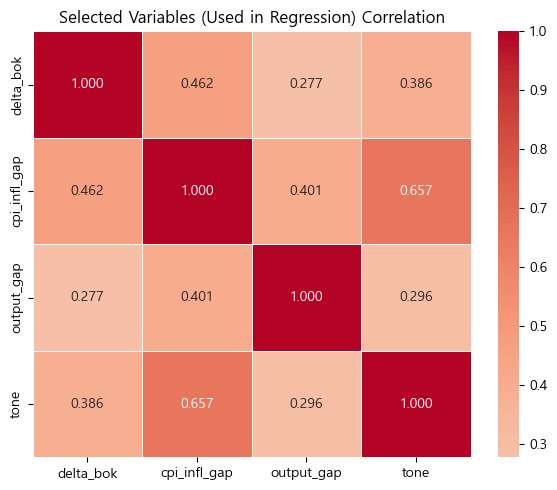

In [62]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# =========================
# 0) (선택) 한글 폰트
# =========================
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False


# =========================
# 1) 유틸: 숫자형 안전 변환
# =========================
def _to_numeric_safe(s: pd.Series) -> pd.Series:
    return pd.to_numeric(
        s.astype(str)
         .str.replace(",", "", regex=False)
         .str.replace("%", "", regex=False)
         .str.strip(),
        errors="coerce"
    )


# =========================
# 2) 메인 함수: Lag-1 OLS + (White/HAC) + 옵션 표준화
# =========================
def run_final_analysis(
    df: pd.DataFrame,
    target_col: str,
    feature_cols: list,
    maxlags: int = 4,
    standardize_cols=None,   # 표준화할 X 컬럼들(=feature_cols 중 일부)
    digits: int = 6          # 출력 소수 자리
):
    """
    t-1 시차 회귀분석:
    - y: target_col (t)
    - X: feature_cols를 shift(1) 해서 X(t-1)로 y(t) 설명
    - 표준화 옵션: standardize_cols에 지정된 X만 z-score
    - White(HC1) / HAC(Newey-West) 둘 다 산출
    """
    df_ana = df.copy()

    # 0) 컬럼명 공백 제거
    df_ana.columns = df_ana.columns.str.strip()

    # 1) 필요한 컬럼 숫자형 변환
    need_cols = list(set(feature_cols + [target_col]))
    for c in need_cols:
        if c in df_ana.columns:
            df_ana[c] = _to_numeric_safe(df_ana[c])

    # 2) X만 lag1 (y는 그대로)
    df_ana[feature_cols] = df_ana[feature_cols].shift(1)

    # 3) 결측 제거
    df_ana = df_ana.dropna(subset=feature_cols + [target_col]).copy()

    # 4) (옵션) X 표준화: 지정된 컬럼만
    if standardize_cols is not None and len(standardize_cols) > 0:
        for c in standardize_cols:
            if c in df_ana.columns:
                std = df_ana[c].std(ddof=0)
                if std == 0 or np.isnan(std):
                    continue
                df_ana[c] = (df_ana[c] - df_ana[c].mean()) / std

    # 5) 회귀
    X = sm.add_constant(df_ana[feature_cols])
    y = df_ana[target_col]

    model_white = sm.OLS(y, X).fit(cov_type="HC1")
    model_hac   = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})

    # 6) 결과표(계수는 HAC 기준 + pvalue 둘 다)
    rows = []
    for col in X.columns:
        rows.append({
            "Variable": col,
            "Coef(HAC)": float(model_hac.params[col]),
            "White_P": float(model_white.pvalues[col]),
            "HAC_P": float(model_hac.pvalues[col])
        })

    out = pd.DataFrame(rows).round(digits)

    info = {
        "nobs": int(model_white.nobs),
        "r2": float(model_white.rsquared),
        "adj_r2": float(model_white.rsquared_adj),
        "start": df_ana.index.min(),
        "end": df_ana.index.max(),
        "maxlags": maxlags
    }

    return out, model_white, model_hac, df_ana, info


# =========================
# 3) 실행부
# =========================
# ✅ 이미 df_final = pd.read_csv("final_monthly_merged_renamed.csv") 로 로드된 상태라고 가정!

df_final = df_final.copy()
df_final.columns = df_final.columns.str.strip()
df_final = df_final.sort_index()

target_col = "delta_bok"

# ✅ delta_bok(t-1) (자기시차항) 제거 버전
feature_cols_selected = [
    "cpi_infl_gap",
    "output_gap",
    "tone"
]

# -------------------------
# A) 원단위(비표준화) 회귀
# -------------------------
res_raw, mW_raw, mH_raw, df_used_raw, info_raw = run_final_analysis(
    df=df_final,
    target_col=target_col,
    feature_cols=feature_cols_selected,
    maxlags=4,
    standardize_cols=None,
    digits=6
)

print("=== [RAW] Lag-1 OLS (White R² 기준) ===")
print(
    f"기간: {info_raw['start']} ~ {info_raw['end']} | "
    f"n={info_raw['nobs']} | R²={info_raw['r2']:.4f} | Adj R²={info_raw['adj_r2']:.4f} | "
    f"HAC maxlags={info_raw['maxlags']}"
)
display(res_raw)


# -------------------------
# B) 표준화 회귀 (해석용 추천)
#   - 거시/톤 변수만 표준화
# -------------------------
standardize_cols = ["cpi_infl_gap", "output_gap", "tone"]

res_std, mW_std, mH_std, df_used_std, info_std = run_final_analysis(
    df=df_final,
    target_col=target_col,
    feature_cols=feature_cols_selected,
    maxlags=4,
    standardize_cols=standardize_cols,
    digits=6
)

print("\n=== [STANDARDIZED X] Lag-1 OLS (White R² 기준) ===")
print(
    f"기간: {info_std['start']} ~ {info_std['end']} | "
    f"n={info_std['nobs']} | R²={info_std['r2']:.4f} | Adj R²={info_std['adj_r2']:.4f} | "
    f"HAC maxlags={info_std['maxlags']}"
)
display(res_std)
# =========================
# C) tone 제외 모델 + 비교 (With tone vs Without tone)
# =========================
feature_cols_no_tone = [
    "cpi_infl_gap",
    "output_gap"
]

# (표준화도 tone 없는 버전으로)
res_std_no_tone, mW_std_no_tone, mH_std_no_tone, df_used_std_no_tone, info_std_no_tone = run_final_analysis(
    df=df_final,
    target_col=target_col,
    feature_cols=feature_cols_no_tone,
    maxlags=4,
    standardize_cols=["cpi_infl_gap", "output_gap"],
    digits=6
)

print("\n=== [STANDARDIZED X] tone 제외 모델 ===")
print(
    f"기간: {info_std_no_tone['start']} ~ {info_std_no_tone['end']} | "
    f"n={info_std_no_tone['nobs']} | R²={info_std_no_tone['r2']:.4f} | Adj R²={info_std_no_tone['adj_r2']:.4f} | "
    f"HAC maxlags={info_std_no_tone['maxlags']}"
)
display(res_std_no_tone)

print("\n=== tone 포함/제외 R² 비교(White 기준) ===")
display(pd.DataFrame([
    {"Model": "With tone", "R2": info_std["r2"], "Adj_R2": info_std["adj_r2"], "n": info_std["nobs"]},
    {"Model": "Without tone", "R2": info_std_no_tone["r2"], "Adj_R2": info_std_no_tone["adj_r2"], "n": info_std_no_tone["nobs"]}
]).round(4))


# =========================
# (옵션) 회귀에 실제 사용된 데이터 기준 히트맵
# =========================
heatmap_vars = [target_col] + feature_cols_selected
heatmap_vars = list(dict.fromkeys(heatmap_vars))  # 중복 제거

corr_small = df_used_std[heatmap_vars].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_small, annot=True, fmt=".3f", cmap="coolwarm", center=0, linewidths=0.4)
plt.title("Selected Variables (Used in Regression) Correlation")
plt.tight_layout()
plt.show()


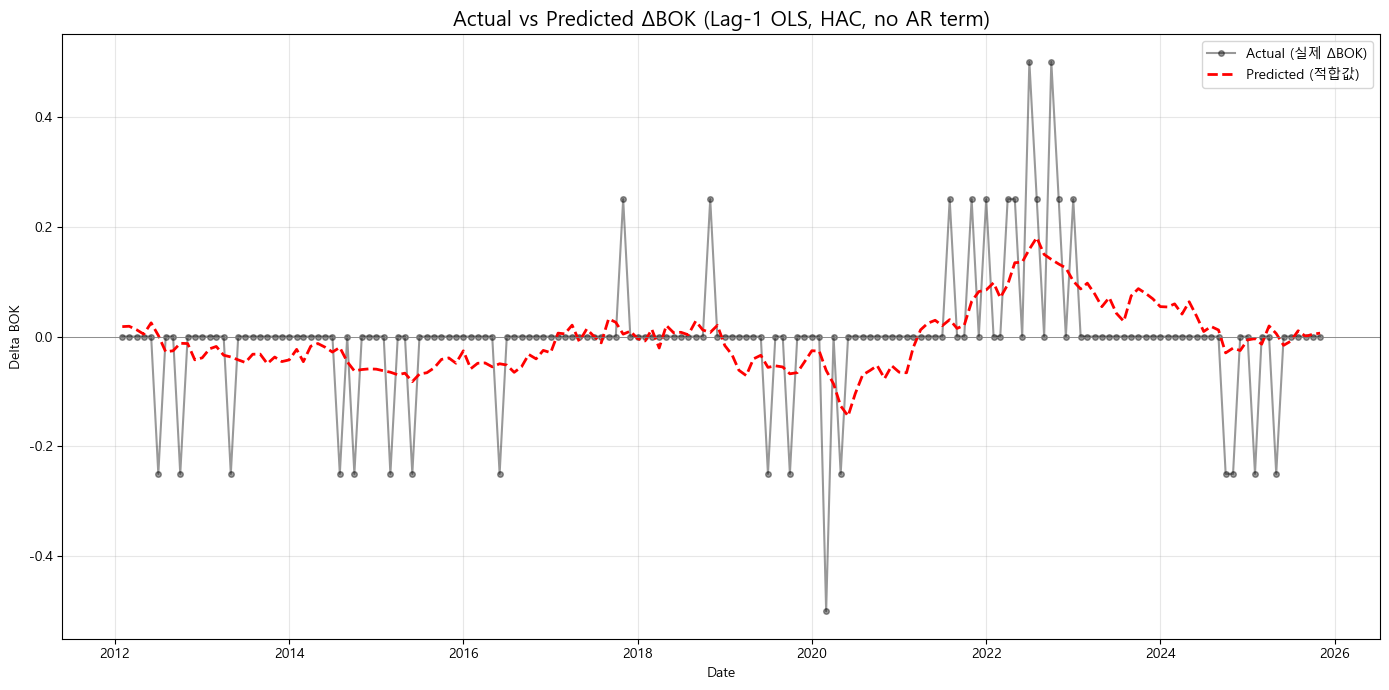

[예측 오차] MAE = 0.069873 | RMSE = 0.103182
최종 분석 결과(166건)가 'final_analysis_result_lag1_no_AR.csv'로 저장되었습니다!


In [61]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0) 사용할 모델/데이터 지정
# =========================
best_model = mH_std        # ✅ delta_bok 제외 + HAC 모델
df_ana = df_used_std.copy()

feature_cols_our = [
    "cpi_infl_gap",
    "output_gap",
    "tone"
]

target_col = "delta_bok"


# =========================
# 1) 예측용 X / 실제 y
# =========================
X_final = sm.add_constant(df_ana[feature_cols_our], has_constant="add")
y_actual = df_ana[target_col]


# =========================
# 2) 예측치(적합값)
# =========================
df_ana["predicted_delta"] = best_model.predict(X_final)


# =========================
# 3) 시각화
# =========================
# PeriodIndex → Timestamp (matplotlib 호환)
x = df_ana.index.to_timestamp()

plt.figure(figsize=(14, 7))

plt.plot(
    x, y_actual.values,
    label="Actual (실제 ΔBOK)",
    color="black", marker="o", markersize=4, alpha=0.4
)

plt.plot(
    x, df_ana["predicted_delta"].values,
    label="Predicted (적합값)",
    color="red", linestyle="--", linewidth=2
)

plt.title("Actual vs Predicted ΔBOK (Lag-1 OLS, HAC, no AR term)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Delta BOK")
plt.axhline(0, color="gray", linewidth=0.6)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# =========================
# 4) 오차 지표
# =========================
mae = np.mean(np.abs(y_actual - df_ana["predicted_delta"]))
rmse = np.sqrt(np.mean((y_actual - df_ana["predicted_delta"])**2))

print(f"[예측 오차] MAE = {mae:.6f} | RMSE = {rmse:.6f}")


# =========================
# 5) 결과 저장
# =========================
out_path = "final_analysis_result_lag1_no_AR.csv"
df_ana.to_csv(out_path, encoding="utf-8-sig")
print(f"최종 분석 결과({len(df_ana)}건)가 '{out_path}'로 저장되었습니다!")
